In [26]:
import matplotlib.pyplot as plt
import numpy as np
from utils.model import load_model
from sklearn.decomposition import PCA
import os
import pandas as pd
import scipy
import torch
os.chdir("/mnt/c/Users/Hillary Hauger/Documents/Studium/SoSe2024/Case Study Non Linear Optimization/Code/latent-communication")
print("Current working directory: ", os.getcwd())
from utils.get_mapping import load_mapping

def get_matrix_from_mapping(mapping, mapping_name,return_b=False):
    if mapping_name == "Linear":
        A = mapping.A.value
        return A
    elif mapping_name == "Affine":
        A = mapping.A_aff.value
        b = mapping.b_aff.value
        if return_b:
            return A,b
        else:
            return A
        
def get_mapping_path(name_model,file1,file2,mapping_name,num_samples,lamda,sampling_strategy,dataset):
    if name_model == "VerySmall-AE":
        mapping_path = f'results/transformations/mapping_files/{name_model}/{file1} {file2} {mapping_name}_{num_samples}_{lamda}_{sampling_strategy}'
    elif name_model == "VAE":
        mapping_path = f'results/transformations/mapping_files/{name_model}/{dataset}/{file1}>{file2}>{mapping_name}_{num_samples}_{lamda}_{sampling_strategy}'
    elif name_model == "PCKTAE":
        mapping_path = f'results/transformations/mapping_files/{name_model}/{file1}>{file2}>{mapping_name}_{num_samples}_{lamda}_{sampling_strategy}'
    return mapping_path

Current working directory:  /mnt/c/Users/Hillary Hauger/Documents/Studium/SoSe2024/Case Study Non Linear Optimization/Code/latent-communication


In [11]:
dataset="FMNIST"
num_samples = 10
mapping_name = "Linear"
lamda = 0
sampling_strategy = "equally"
#name_model = "VerySmall-AE"
name_model = "PCKTAEClASS01234"
seed1,seed2,seed3 = 1,2,3
size_of_the_latent = 10


file1 = f"{dataset}_{name_model}_{size_of_the_latent}_{seed1}.pth"
file2 = f"{dataset}_{name_model}_{size_of_the_latent}_{seed2}.pth"
file3 = f"{dataset}_{name_model}_{size_of_the_latent}_{seed3}.pth"

In [12]:
if name_model == "VerySmall_AE"  or name_model == "PCKTAEClASS01234":
    mapping_path1 = f'results/transformations/mapping_files/{name_model}/{file1.strip(".pth")} {file2.strip(".pth")} {mapping_name}_{num_samples}_{lamda}_{sampling_strategy}'
    mapping_path2 = f'results/transformations/mapping_files/{name_model}/{file1.strip(".pth")} {file3.strip(".pth")} {mapping_name}_{num_samples}_{lamda}_{sampling_strategy}'
elif name_model == "VAE":
    mapping_path1 = f'results/transformations/mapping_files/{name_model}/{dataset}/{file1.strip(".pth")}>{file2.strip(".pth")}>{mapping_name}_{num_samples}_{lamda}_{sampling_strategy}'
    mapping_path2 = f'results/transformations/mapping_files/{name_model}/{dataset}/{file1.strip(".pth")}>{file3.strip(".pth")}>{mapping_name}_{num_samples}_{lamda}_{sampling_strategy}'
elif name_model == "PCKTAE":
    mapping_path1 = f'results/transformations/mapping_files/{name_model}/{file1.strip(".pth")}>{file2.strip(".pth")}>{mapping_name}_{num_samples}_{lamda}_{sampling_strategy}'
    mapping_path2 = f'results/transformations/mapping_files/{name_model}/{file1.strip(".pth")}>{file3.strip(".pth")}>{mapping_name}_{num_samples}_{lamda}_{sampling_strategy}'

mapping1 = load_mapping(mapping_path1,mapping_name)
mapping2 = load_mapping(mapping_path2,mapping_name)

In [13]:
A1 = get_matrix_from_mapping(mapping1,mapping_name)
A2 = get_matrix_from_mapping(mapping2,mapping_name)
#Calculate the eigenvalues and eigenvectors
eigenvalues1, eigenvectors1 = np.linalg.eig(A1.T@A1)
eigenvalues2, eigenvectors2 = np.linalg.eig(A2.T@A2)
#Convert eigenvalues to real numbers
eigenvalues1 = np.real(eigenvalues1)
eigenvalues2 = np.real(eigenvalues2)
#Convert eigenvectors to real numbers
eigenvectors1 = np.real(eigenvectors1)
eigenvectors2 = np.real(eigenvectors2)

In [14]:
# Sort eigenvalues and eigenvectors
idx1 = eigenvalues1.argsort()[::-1]
eigenvalues1 = eigenvalues1[idx1]
eigenvectors1 = eigenvectors1[:,idx1]
idx2 = eigenvalues2.argsort()[::-1]
eigenvalues2 = eigenvalues2[idx2]
eigenvectors2 = eigenvectors2[:,idx2]

In [15]:
# Print eigenvalues of both mappigns
print("Eigenvalues of the first mapping:")
print(eigenvalues1)
print("Eigenvalues of the second mapping:")
print(eigenvalues2)

Eigenvalues of the first mapping:
[6.26021988 1.53330002 1.29560181 1.15966796 0.91226694 0.76325521
 0.74246142 0.64307364 0.46415569 0.11931627]
Eigenvalues of the second mapping:
[23.73047262  1.54706289  1.27210575  1.12871688  0.79878246  0.73995574
  0.71976521  0.58601372  0.08961228  0.05074342]


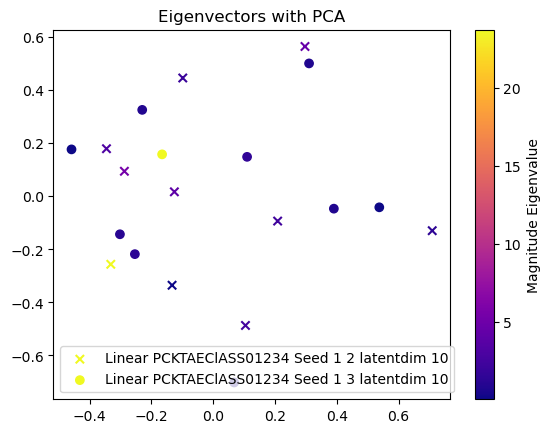

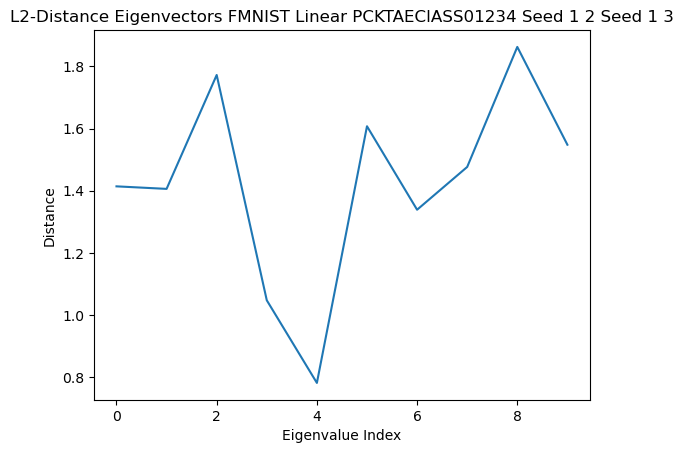

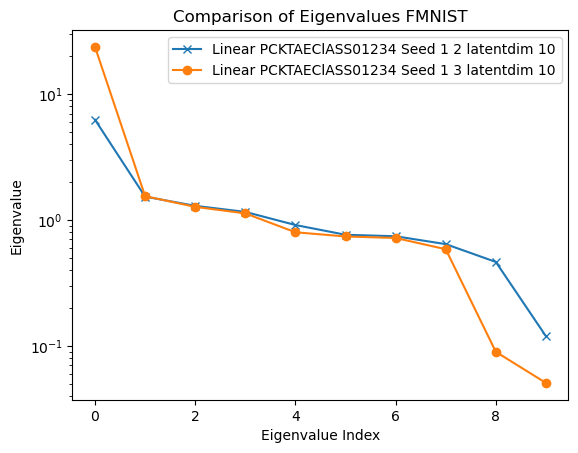

In [16]:
# Perform PCA on eigenvectors1
pca = PCA(n_components=2)
eigenvectors1_pca = pca.fit_transform(eigenvectors1)
eigenvectors2_pca = pca.transform(eigenvectors2)
mapping_label1=f'{mapping_name} {name_model} Seed {seed1} {seed2} latentdim {size_of_the_latent}'
mapping_label2= f'{mapping_name} {name_model} Seed {seed1} {seed3} latentdim {size_of_the_latent}'
# Plot eigenvectors with PCA of the first mapping
plt.scatter(eigenvectors1_pca[:, 0], eigenvectors1_pca[:, 1],marker = 'x', c=eigenvalues1, cmap='plasma', label=mapping_label1)
plt.scatter(eigenvectors2_pca[:, 0], eigenvectors2_pca[:, 1],marker='o', c=eigenvalues2, cmap='plasma', label=mapping_label2)
plt.colorbar(label='Magnitude Eigenvalue')
plt.legend()
plt.title('Eigenvectors with PCA')
plt.show()

# Plot the distances between the eigenvectors
distances = np.linalg.norm(eigenvectors1 - eigenvectors2, axis=1)
plt.plot(range(len(distances)), distances)
plt.xlabel('Eigenvalue Index')
plt.ylabel('Distance')
plt.title(f'L2-Distance Eigenvectors {dataset} {mapping_name} {name_model} Seed {seed1} {seed2} Seed {seed1} {seed3}')
plt.show()

# Compare the eigenvalues of the two mappings with a plot
plt.plot(range(len(eigenvalues1)), eigenvalues1, label=mapping_label1,marker='x')
plt.plot(range(len(eigenvalues2)), eigenvalues2, label=mapping_label2,marker='o')
plt.yscale('log')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.title(f'Comparison of Eigenvalues {dataset}')
plt.legend()
plt.show()

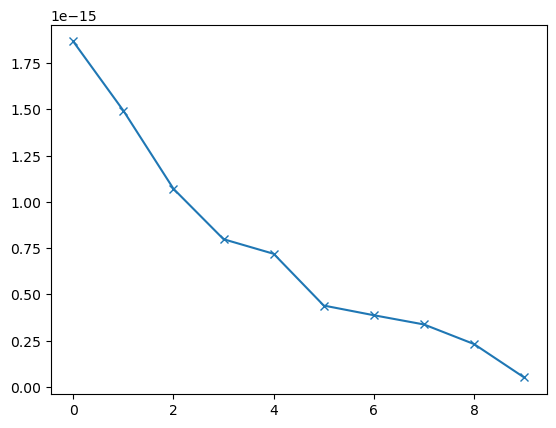

In [17]:
#Calculate the principal angles between the two subspaces
principal_angles = scipy.linalg.subspace_angles(A1, A2)
# plot principal angles
plt.plot(range(len(principal_angles)), principal_angles,marker='x')

In [22]:
# Load the corresponding models
path_model1 = f"models/checkpoints/SMALLAE_classes0_1_2_3_4/{dataset}/{file1}"
model1 = load_model("PCKTAE",path_model1,latent_size=10) # I need to dvc pull first
decoded_eigenvectors = model1.decode(torch.tensor(eigenvectors1,dtype = torch.float32)).detach().numpy().squeeze()

5


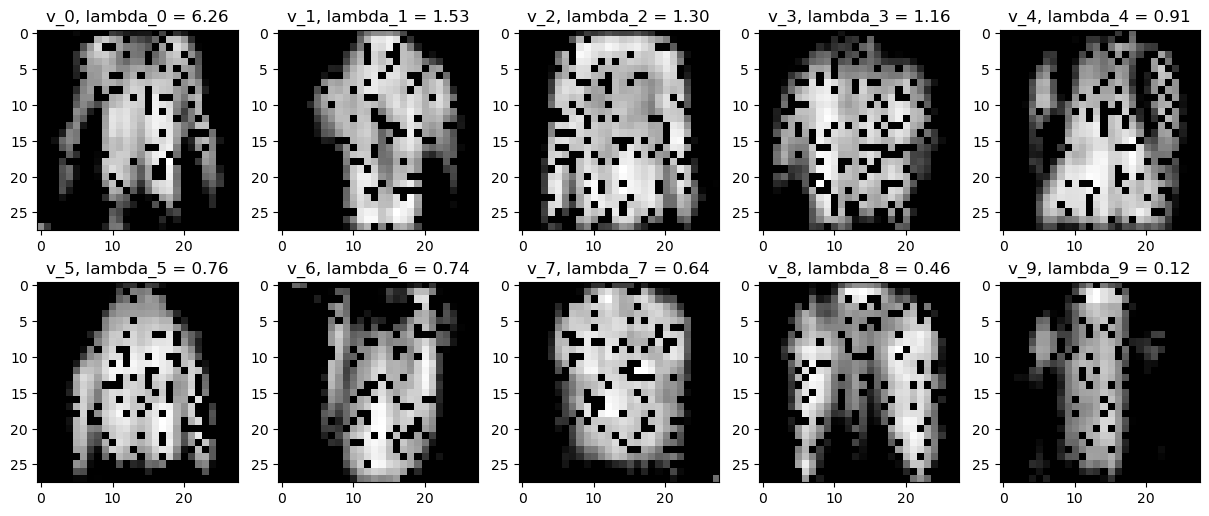

In [40]:

n_col = 5
n_rows = int(decoded_eigenvectors.shape[0]//n_col)
print(n_col)
fig,axs = plt.subplots(n_rows,n_col,figsize=(n_col*3,n_rows*3))
for i in range(n_rows):
    for j in range(n_col):
        axs[i,j].set_title(f"v_{i*n_col+j}, lambda_{i*n_col+j} = {eigenvalues1[i*n_col+j]:.2f}")
        axs[i,j].imshow(decoded_eigenvectors[i*n_col+j], cmap='gray')

In [47]:
number_samples = [10,50,100,200] 
size_of_latents = [10, 30, 50]
mapping_list = ["Linear"]
lamda_list = [0,0.01,0.001]
name_model = "VAE"
seeds = [1,2]
  
mapping_list = ["Linear", "Affine"]
lamda_list = [0,0.01,0.001]    #[0,0.1, 0.01]
use_test_set = False
sampling_strategy = "equally"
results = []
#Create combination of all parameters
for seed1 in seeds:
    for seed2 in seeds:
        if seed1 != seed2:
            for num_samples in number_samples:
                for lamda in lamda_list:
                    for size_of_the_latent in size_of_latents:
                        file1 = f"{dataset}_{name_model}_{size_of_the_latent}_{seed1}"
                        file2 = f"{dataset}_{name_model}_{size_of_the_latent}_{seed2}"
                        #mapping_path = f'results/transformations/mapping_files/{name_model}/{file1}>{file2}>{mapping_name}_{num_samples}_{lamda}_{sampling_strategy}'
                        #Load mapping
                        mapping_path = get_mapping_path(name_model,file1,file2,mapping_name,num_samples,lamda,sampling_strategy,dataset)
                        mapping = load_mapping(mapping_path,mapping_name)
                        A = get_matrix_from_mapping(mapping,mapping_name)
                        #Calculate eigenvalues and eigenvectors
                        eigenvalues, eigenvectors = np.linalg.eig(A.T@A)
                        #Convert eigenvalues to real numbers
                        eigenvalues = np.real(eigenvalues)
                        eigenvectors = np.real(eigenvectors)
                        #Sort eigenvalues and eigenvectors
                        idx = eigenvalues.argsort()[::-1]
                        eigenvalues = eigenvalues[idx]
                        eigenvectors = eigenvectors[:,idx]
                        results.append({
                            "dataset": dataset,
                            "model1": file1,
                            "model2": file2,
                            "seed1": seed1,
                            "seed2":seed2,
                            "latentdim": size_of_the_latent,
                            "mapping": mapping_name,
                            "lambda": lamda,
                            "num_samples": num_samples,
                            "eigenvalues": eigenvalues,
                            "eigenvectors": eigenvectors
                            })

results = pd.DataFrame(results)

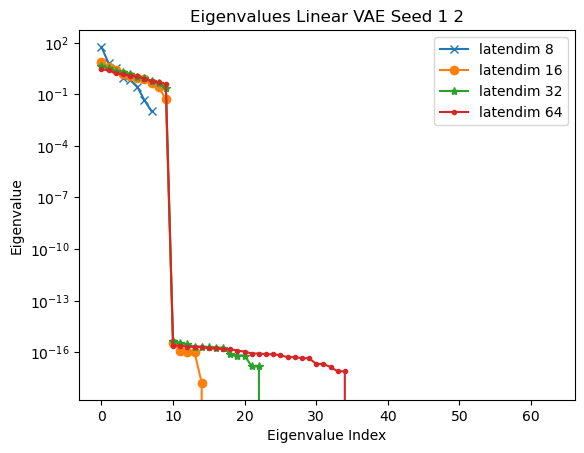

In [51]:
#Plot the eigenvalues dependent on the latent dim
markers = ['x','o','*',".","^"]
#Get eigenvalues from results dataframe where seed1 =1 seed2= 2 lamda = 0 num_samples = 10
mask = (results.seed1 == 1) & (results.seed2 == 2) & (results["lambda"] == 0) & (results.num_samples == number_samples[0])
plt.title(f"Eigenvalues {mapping_name} {name_model} Seed 1 2")

for i,latendim in enumerate(size_of_latents):
    selected_eigenvalues = results[mask & (results.latentdim == latendim)].eigenvalues.values[0]
    plt.plot(selected_eigenvalues, label=f"latendim {latendim}",marker = markers[i])


plt.yscale('log')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.legend()
plt.savefig(f"results/figures/eigenvalues_latentdim_{mapping_name}_{name_model}_seed_1_2.png")
plt.show()

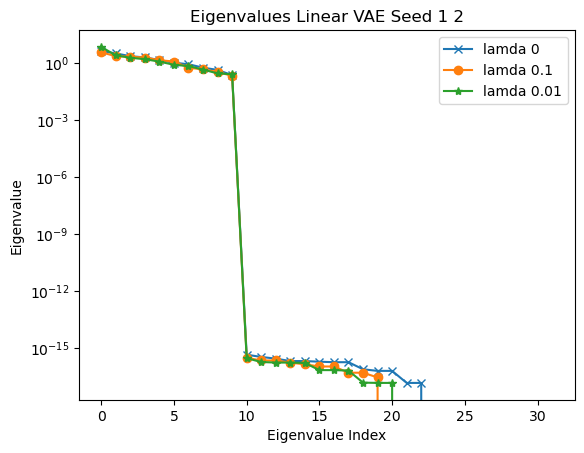

In [44]:
#Plot the eigenvalues dependent on the lamda
#Get eigenvalues from results dataframe where seed1 =1 seed2= 2 lamda = 0 num_samples = 10
mask = (results.seed1 == 1) & (results.seed2 == 2) & (results.latentdim == size_of_latents[2]) & (results.num_samples == number_samples[0])
plt.title(f"Eigenvalues {mapping_name} {name_model} Seed 1 2")
for i,lamda in enumerate(lamda_list):
    selected_eigenvalues = results[mask & (results["lambda"] == lamda)].eigenvalues.values[0]
    plt.plot(selected_eigenvalues, label=f"lamda {lamda}",marker = markers[i])

plt.yscale('log')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.legend()
plt.savefig(f"results/figures/eigenvalues_lambda_{mapping_name}_{name_model}_seed_1_2.png")
plt.show()

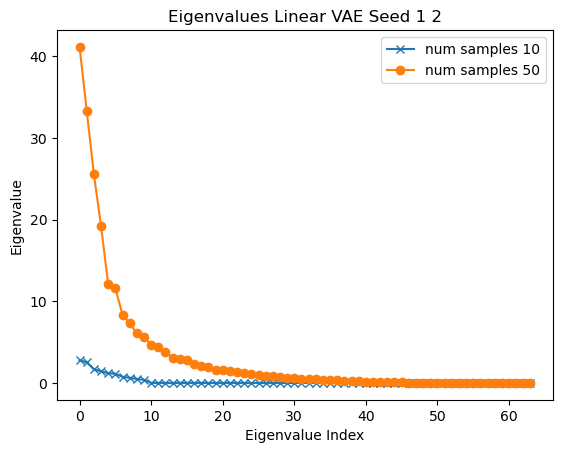

In [49]:
#Plot the eigenvalues dependent on the num_samples
#Get eigenvalues from results dataframe where seed1 =1 seed2= 2 lamda = 0 num_samples = 10
mask = (results.seed1 == 1) & (results.seed2 == 2) & (results.latentdim == size_of_latents[3]) & (results["lambda"] == 0.0)

plt.title(f"Eigenvalues {mapping_name} {name_model} Seed 1 2")
for i,num_sample in enumerate(number_samples):
    selected_eigenvalues = results[mask & (results.num_samples == num_sample)].eigenvalues.values[0]
    plt.plot(selected_eigenvalues, label=f"num samples {num_sample}",marker = markers[i])

#plt.yscale('log')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.legend()
plt.savefig(f"results/figures/eigenvalues_num_samples_{mapping_name}_{name_model}_seed_1_2.png")
plt.show()